<a href="https://colab.research.google.com/github/yh0010/ML_Final_Project/blob/main/CNN(Resnet18)_Differential_Privacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Before the Deep Dive:

**1. General purpose:**

This entire notebook serves the purpose as the extension notebook to our federated learning project as a comparison technique regarding the topic of privacy.

This notebook also has its replication and its extension parts both are commented specifically in their code blocks.


**2. General introduction to Differential Privacy:**

In this notebook, we specifically dedicated to demonstrate a branch of the differential privacy family ---- differential privacy-stochastic gradient descent(DP-SGD).

DP-SGD is a privacy-preserving technique by adding noise to the aggregated per-sample gradients when computing backward pass.

> $Pr[M(x) \in S] \leq exp(\epsilon)Pr[M(y) \in S] + \delta$


It provides mathematically guarantees, For a randomized algorithm M, S is the set of all potential output of M that could be predicted. In between x and y databases, adding the epsilon noise as the maximum distance plus the failure probability delta as the accidental leaking information.

Small epsilon will provide very similar outputs with the given inputs.

Large epsilon provides less similarity in between the outputs and inputs.

For delta, when it equals to 0 meaning that there’s 0 probability to leak data.

**3. Why do we choose this technique?**

In our research, we discover that many researchers like to combine federated learning and differential privacy when training the model. Because each of these technique can provide a unique protection that the others cannot cover. So we decide to make them compare to each other and demonstrate their unique strengths in privacy preserving.

**4. General guideline of this notebook**

This notebook contains two models, one trained with DPSGD and one without (by using a pre-trained & modified model ResNet18. In the end the an accuracy table is presented to compare their performance. All coding blocks are commented with more details as you read through the following.


# CNN(Resnet18) with differential privacy

In [ ]:
#Import all the necessary libraries

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import numpy as np

In [ ]:
#install the OPACUS to enable DP feature

!pip install opacus

     |████████████████████████████████| 144 kB 5.0 MB/s 


## Hyper-parameters

**NOTES: This text block is given by the original replication notebook. The following text explains the important hyper-parameters in details.**


To train a model with Opacus there are three privacy-specific hyper-parameters that must be tuned for better performance:

* Max Grad Norm: The maximum L2 norm of per-sample gradients before they are aggregated by the averaging step.
* Noise Multiplier: The amount of noise sampled and added to the average of the gradients in a batch.
* Delta: The target δ of the (ϵ,δ)-differential privacy guarantee. Generally, it should be set to be less than the inverse of the size of the training dataset. In this tutorial, it is set to $10^{−5}$ as the CIFAR10 dataset has 50,000 training points.

We use the hyper-parameter values below to obtain results in the last section:

In [ ]:
#NOTES:

#This is a replicated code block

#codes explain: Define basic parameters for the training

import warnings
warnings.simplefilter("ignore")

MAX_GRAD_NORM = 1.2
EPSILON = 50.0
DELTA = 1e-5
EPOCHS = 20

LR = 1e-3

**NOTES: This text block is given by the original replication notebook. The following text explains the importance to implement BatchMemoryManager.**

There's another constraint we should be mindful of&mdash;memory. To balance peak memory requirement, which is proportional to `batch_size^2`, and training performance, we will be using BatchMemoryManager. It separates the logical batch size (which defines how often the model is updated and how much DP noise is added), and a physical batch size (which defines how many samples do we process at a time).

With BatchMemoryManager you will create your DataLoader with a logical batch size, and then provide maximum physical batch size to the memory manager.

In [ ]:
#NOTES:

#This is a replicated code block

#codes explain: Define basic parameters for the training

BATCH_SIZE = 512
MAX_PHYSICAL_BATCH_SIZE = 128

## Data

### Install data from kaggle - Peumonia vs Normal chest X-rays

To download datasets from Kaggle.com. First you have to generate a new API token from your profile, upload it in here then run the remaining commands.

The token file is called kaggle.json

In [ ]:
#NOTES:

#This is an extended code block that's a replication of an outside source

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#NOTES:

#This is an extended code block that's a replication of an outside source

! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:26<00:00, 33.5MB/s]
100% 2.29G/2.29G [00:27<00:00, 91.1MB/s]


In [ ]:
#NOTES:

#This is an extended code block that's a replication of an outside source

#the downloaded datasets are still zipped
#here we use zipfile library to unzip them

import zipfile

zf = "/content/chest-xray-pneumonia.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"

zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

**Source for the above codes:**
https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a

###Create dataloader for pytorch

We have to create this customized data loader as Pytorch only takes in the data loader for parameter when training the model.

In [ ]:
#NOTES:

#This is an extended code block
#To make a simplified version of transforms, we used the same self-defined global_transforms variable in both of our notebooks

#define global transformations for all datasets
global_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.ToTensor()
  ])

In [ ]:
#NOTES:

#This is an extended code block that's a replication of an outside source

data = {
    'train':
    datasets.ImageFolder(root="/content/dataset/cnn/pneumonia_revamped/chest_xray/train", transform=global_transforms),
    'val':
    datasets.ImageFolder(root="/content/dataset/cnn/pneumonia_revamped/chest_xray/val", transform=global_transforms),
    'test':
    datasets.ImageFolder(root="/content/dataset/cnn/pneumonia_revamped/chest_xray/test", transform=global_transforms)
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(data['val'], batch_size=BATCH_SIZE, shuffle=True),
    'test': DataLoader(data['test'], batch_size=BATCH_SIZE, shuffle=True)
}

**Source for the boce codes:**
https://www.kaggle.com/dnik007/pneumonia-detection-using-pytorch


### Image plotting

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

To give out a visual on how the image datasets look like.

*************************************************************************

NORMAL


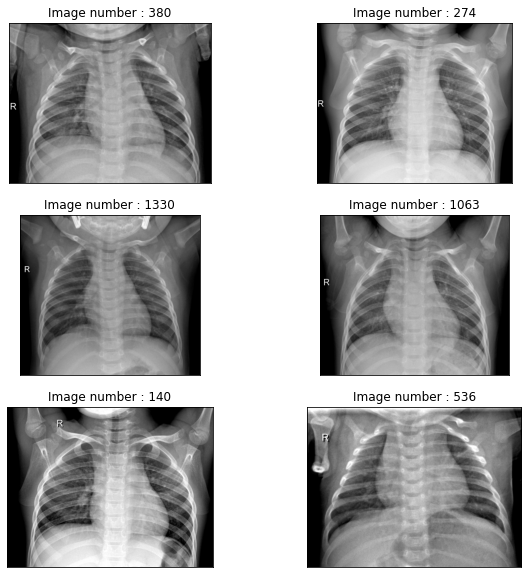

*************************************************************************

PNEUMONIA


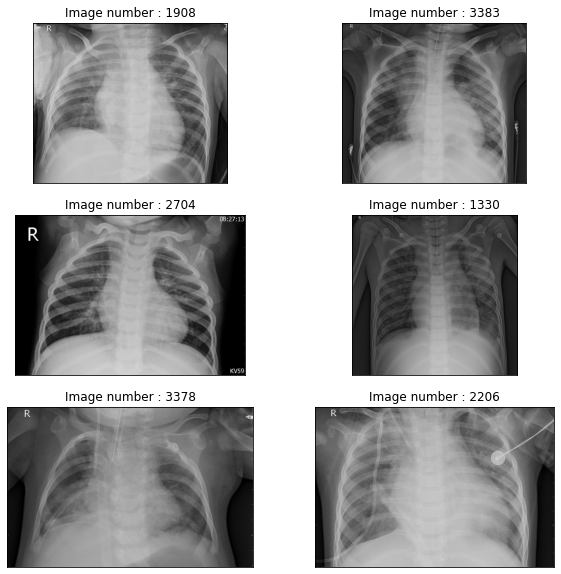

*************************************************************************



In [ ]:
#NOTES:

#This is an extended code block that's a replication of an outside source

#only use training data to plot
train_normal_path = "/content/dataset/cnn/pneumonia_revamped/chest_xray/train/NORMAL"
train_pneu_path = "/content/dataset/cnn/pneumonia_revamped/chest_xray/train/PNEUMONIA"

train_normal_list = [os.path.join(train_normal_path, x) for  x in os.listdir(train_normal_path)]
train_pneu_list = [os.path.join(train_pneu_path, x) for x in os.listdir(train_pneu_path)]

print('*************************************************************************\n')
#Checking images 
rnd_idx = np.random.randint(0, len(train_normal_list), 6)
print('NORMAL')
plt.figure(figsize = (10,10))
for idx, rn in enumerate(rnd_idx):
    img = cv2.imread(train_normal_list[idx], cv2.IMREAD_COLOR)
    plt.subplot(3,2,idx+1)
    plt.title('Image number : {}'.format(rn))
    plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
    plt.imshow(img)
plt.show()

print('*************************************************************************\n')
rnd_idx = np.random.randint(0, len(train_pneu_list), 6)
print('PNEUMONIA')
plt.figure(figsize = (10,10))
for idx, rn in enumerate(rnd_idx):
    img = cv2.imread(train_pneu_list[idx], cv2.IMREAD_COLOR)
    plt.subplot(3,2,idx+1)
    plt.title('Image number : {}'.format(rn))
    plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
    plt.imshow(img)
plt.show()
print('*************************************************************************\n')


**Source for the above codes:**
https://www.kaggle.com/minfa1207/cnn-pytorch-loss-0-9991-acc-87-6


## Model

In [ ]:
#NOTES:

#This is a replicated code block with modification, the original is num_classes = 10

#create model instance

from torchvision import models

model = models.resnet18(num_classes=2)

In order to use Opacus on this resnet18 model. Suggested by the original notebook, we have to call ModuleValidator to modify this model because Opacus does not support all types of Pytorch layers.

ModuleValidator tries to find the best replacement for incompatible modules. In this case, the problem is BatchNorm modules (shown in the original notebook). The validator replaces it with GroupNorm.

In [ ]:
#NOTES:

#This is a replicated code block

from opacus.validators import ModuleValidator

model = ModuleValidator.fix(model)
ModuleValidator.validate(model, strict=False)

[]

**NOTES: This text block is given by the original replication notebook. The following text explains the importance of CUDA utilization.**

For maximal speed, we can check if CUDA is available and supported by the PyTorch installation. If GPU is available, set the `device` variable to your CUDA-compatible device. We can then transfer the neural network onto that device.

In [ ]:
#NOTES:

#This is a replicated code block

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

We then define our optimizer and loss function. Opacus’ privacy engine can attach to any (first-order) optimizer.  

In [ ]:
#NOTES:

#This is a replicated code block

import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer1 = optim.RMSprop(model.parameters(), lr=LR)

### Prepare for Training

We will define a util function to calculate accuracy

In [ ]:
#NOTES:

#This is a replicated code block

def accuracy_func(preds, labels):
    return (preds == labels).mean()

We now attach the privacy engine initialized with the privacy hyperparameters defined earlier.

In [ ]:
#NOTES:

#This is a replicated code block

from opacus import PrivacyEngine

privacy_engine = PrivacyEngine()

model, optimizer, data_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer1,
    data_loader=dataloaders['train'],
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM,
)

print(f"Using sigma={optimizer.noise_multiplier} and C={MAX_GRAD_NORM}")


Using sigma=0.4882763671875 and C=1.2


We will then define our train function. This function will train the model for one epoch. 

In [ ]:
#NOTES:

#This is a replicated code block

import numpy as np
from opacus.utils.batch_memory_manager import BatchMemoryManager


def train(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()

    losses = []
    top1_acc = []
    
    with BatchMemoryManager(
        data_loader=dataloaders['train'], 
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
        optimizer=optimizer
    ) as memory_safe_data_loader:

        for i, (images, target) in enumerate(memory_safe_data_loader):   
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            # measure accuracy and record loss
            acc = accuracy_func(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

            loss.backward()
            optimizer.step()

            if (i+1) % 200 == 0:
                epsilon = privacy_engine.get_epsilon(DELTA)
                print(
                    f"\tTrain Epoch: {epoch} \t"
                    f"Loss: {np.mean(losses):.6f} "
                    f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
                    f"(ε = {epsilon:.2f}, δ = {DELTA})"
                )



Next, we will define our test function to validate our model on our test dataset. 

In [ ]:
#NOTES:

#This is a replicated code block

def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()
            acc = accuracy_func(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tTest set:"
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)

### Train the network

In [ ]:
#NOTES:

#This is a replicated code block

from tqdm.notebook import tqdm

for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
    train(model, dataloaders['train'], optimizer, epoch + 1, device)

Epoch:   0%|          | 0/20 [00:00<?, ?epoch/s]

### Test the network on test data

In [ ]:
#NOTES:

#This is a replicated code block

dtop1_acc = test(model, dataloaders['test'], device)

	Test set:Acc: 65.290179 


1. Generally speaking, differentially private training is enough of a regularizer by itself. Adding any more regularization (such as dropouts or data augmentation) is unnecessary and typically hurts performance.
2. Tuning MAX_GRAD_NORM is very important. Start with a low noise multiplier like .1, this should give comparable performance to a non-private model. Then do a grid search for the optimal MAX_GRAD_NORM value. The grid can be in the range [.1, 10].


#CNN(Resnet18) without differential privacy

Without differential privacy, there are less parameters that we need to declare.

In [ ]:
#NOTES:

#This is an extended code block 

#codes explain: Define basic parameters for the training

import warnings
warnings.simplefilter("ignore")

EPOCHS = 20
LR = 1e-3
BATCH_SIZE = 512
MAX_PHYSICAL_BATCH_SIZE = 128

## Data

###Create dataloader for pytorch

Since the data has been downloaded previously we can just use them directly, but let's declare the data loader again.

In [ ]:
#NOTES:

#This is an extended code block 

#define global transformations for all datasets
global_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.ToTensor()
  ])

In [ ]:
#NOTES:

#This is an extended code block that's a replication of an outside source

data = {
    'train':
    datasets.ImageFolder(root="/content/dataset/cnn/pneumonia_revamped/chest_xray/train", transform=global_transforms),
    'val':
    datasets.ImageFolder(root="/content/dataset/cnn/pneumonia_revamped/chest_xray/val", transform=global_transforms),
    'test':
    datasets.ImageFolder(root="/content/dataset/cnn/pneumonia_revamped/chest_xray/test", transform=global_transforms)
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(data['val'], batch_size=BATCH_SIZE, shuffle=True),
    'test': DataLoader(data['test'], batch_size=BATCH_SIZE, shuffle=True)
}

**NOTES: the above extended code blocks are the replication from an outside source:**

https://www.kaggle.com/dnik007/pneumonia-detection-using-pytorch


## Model

Create model instance for Resnet18. In here, because we do not need to use Opacus, so we don't have to call ModuleValidator to fix it.

Just proceed to use this instance directly.

In [ ]:
#NOTES:

#This is an extended code block based off on original replication notebook

model = models.resnet18(num_classes=2)

In [ ]:
#NOTES:

#This is an extended code block based off on original replication notebook

# same code to modify CUDA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

Our loss function the optimizer here for the model is the same. However, we are not putting this through BatchMemoryManager because without gradients clipping and adding noise steps, we have enough memory for CUDA to operate on.

In [ ]:
#NOTES:

#This is an extended code block based off on original replication notebook

# import torch.nn as nn
# import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LR)

### Training

In [ ]:
#NOTES:

#This is an extended code block 
#We created this code based on the knowledge of the learned materials from our ML coding lectures.

batches = len(dataloaders['train'])
val_batches = len(dataloaders['val'])

for epoch in range(EPOCHS):
    total_loss = 0

    # progress bar (works in Jupyter notebook too!)
    print("Epochs: ", epoch)
    progress = tqdm(enumerate(dataloaders['train']), desc='Loss', total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    


Epochs:  0


Loss: 0.8300: 100%|██████████| 11/11 [01:29<00:00,  8.09s/it]


Epochs:  1


Loss: 0.4132: 100%|██████████| 11/11 [01:29<00:00,  8.14s/it]


Epochs:  2


Loss: 0.4353: 100%|██████████| 11/11 [01:30<00:00,  8.26s/it]


Epochs:  3


Loss: 0.3622: 100%|██████████| 11/11 [01:30<00:00,  8.20s/it]


Epochs:  4


Loss: 0.3444: 100%|██████████| 11/11 [01:31<00:00,  8.34s/it]


Epochs:  5


Loss: 0.3630: 100%|██████████| 11/11 [01:34<00:00,  8.59s/it]


Epochs:  6


Loss: 0.4017: 100%|██████████| 11/11 [01:32<00:00,  8.39s/it]


Epochs:  7


Loss: 0.3192: 100%|██████████| 11/11 [01:33<00:00,  8.50s/it]


Epochs:  8


Loss: 0.3454: 100%|██████████| 11/11 [01:32<00:00,  8.42s/it]


Epochs:  9


Loss: 0.3204: 100%|██████████| 11/11 [01:32<00:00,  8.43s/it]


Epochs:  10


Loss: 0.3192: 100%|██████████| 11/11 [01:32<00:00,  8.44s/it]


Epochs:  11


Loss: 0.3557: 100%|██████████| 11/11 [01:32<00:00,  8.39s/it]


Epochs:  12


Loss: 0.3015: 100%|██████████| 11/11 [01:32<00:00,  8.42s/it]


Epochs:  13


Loss: 0.3053: 100%|██████████| 11/11 [01:32<00:00,  8.45s/it]


Epochs:  14


Loss: 0.2822: 100%|██████████| 11/11 [01:32<00:00,  8.43s/it]


Epochs:  15


Loss: 0.3565: 100%|██████████| 11/11 [01:30<00:00,  8.26s/it]


Epochs:  16


Loss: 0.2890: 100%|██████████| 11/11 [01:30<00:00,  8.25s/it]


Epochs:  17


Loss: 0.2859: 100%|██████████| 11/11 [01:31<00:00,  8.32s/it]


Epochs:  18


Loss: 0.2843: 100%|██████████| 11/11 [01:31<00:00,  8.28s/it]


Epochs:  19


Loss: 0.2801: 100%|██████████| 11/11 [01:30<00:00,  8.27s/it]


### Testing

In [ ]:
#NOTES:

#This is an extended code block based off on original replication notebook

def accuracy_func(preds, labels):
    return (preds == labels).mean()

In [ ]:
#NOTES:

#This is an extended code block based off on original replication notebook

def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()
            acc = accuracy_func(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)

In [ ]:
#NOTES:

#This is an extended code block based off on original replication notebook

dtop1_acc = test(model, dataloaders['test'], device)

	Test set:Loss: 1.060819 Acc: 66.489955 


## Private Model vs Non-Private Model Performance

**NOTES: The idea of the comparison table its got from the original replication notebook. This is a part of our extension. As we compare the ouput differences between the model with and without DP feature.**

Now, lets compare the accuracy performance between the private and non-private ResNet18 models.

Both of the models have been trained for 20 epochs and using the same hyperparameters. 

Private model has GroupNorm layer and non-private model has BatchNorm layer.

The result are visualized in the below table.

There is an approximate 1.2% difference with epsilon equals to 50. This demonstrates that with a minor accuracy sacrifice, one can achieve a higher privacy guarantees as a worthy tradeoff!

| Model          | Top 1 Accuracy (%) |  ϵ |
|----------------|--------------------|---|
| ResNet         | 66.489955          | ∞ |
| Private ResNet |         65.290179  |  50  |